In [1]:
%pip install pandas

Note: you may need to restart the kernel to use updated packages.


# Import Libraries

In [2]:
import pandas as pd
from collections import Counter, defaultdict
import statistics
import re
import numpy as np
import math

# Data cleaning and preprocessing

In [3]:
def data_cleaning(raw_address):
    data = pd.ExcelFile(raw_address)
    sponsor_id = [5419, 5479, 5550]
    Posting_Des = pd.read_excel(data, 'Posting Descriptions')
    d_likes = pd.read_excel(data, 'Posting Likes')
    d_clicks = pd.read_excel(data, 'Posting Clicks')
    
    df_posting_goals = adding_kid_safety(data)
    
    
    merged_data = likes_by_sponsor(sponsor_id, d_likes, Posting_Des)
    merged_data = clicks_by_sponsor(sponsor_id, d_clicks, merged_data)
    
    
    df_posting_des = description_with_goals(df_posting_goals, Posting_Des)
    
    columns_drop = ['module_code','description']
    df_posting_des = df_posting_des.drop(columns = columns_drop)
    
    for s in sponsor_id:
        clean_data = cleaned_data(merged_data, df_posting_des, s)
        clean_data.to_excel(str(s)+" Cleaned Data.xlsx", index=False)  


def cleaned_data(merged_data, d_postingDes, s):

    result = pd.DataFrame(merged_data['postable_id'])
    
    result['like']=merged_data["likes_" + str(s)]
    result['click']=merged_data["clicks_" + str(s)]
    result = result.merge(d_postingDes, how='left', on='postable_id')
    return result


def description_with_goals(df_posting_goals, Posting_Des):
    df_posting_goals["postable_id"] = df_posting_goals["postable_id"].apply(remove_xx)
    goals_dict = goals_to_dict(df_posting_goals)
    
    original_columns = Posting_Des.columns.tolist()
    original_columns.append('goal')
    original_columns.append('business')
    original_columns.append('not-if')
    original_columns.append('situation')
    updated_df_posting_des = pd.DataFrame()
    for index, row in Posting_Des.iterrows():
        new_row = add_columns_from_dict(row, goals_dict)
        updated_df_posting_des = pd.concat([updated_df_posting_des, pd.DataFrame([new_row])], ignore_index=True)
    df_posting_des = updated_df_posting_des.fillna(0)
    df_posting_des = df_posting_des[original_columns]
    return df_posting_des
    

def clicks_by_sponsor(sponsor_id, clicks_data, merged_data):
    columns_drop=['sponsor_id', 'timestamp', 'postable_type']
    for s in sponsor_id:
        result = clicks_data.loc[clicks_data['sponsor_id'] == s]
        result = result.groupby(['postable_id']).count()
        result = result.reset_index()
        result = result.drop(columns = columns_drop)
        new_col_name = "clicks_" + str(s)
        result = result.rename(columns={"id": new_col_name})
        merged_data = merged_data.merge(result, how='left', on='postable_id')
    merged_data = merged_data.fillna(0)
    return merged_data


def likes_by_sponsor(sponsor_id, likes_data, Posting_Des):
    likes_data=likes_data.drop(labels=["id","postable_type","post_create_time"],axis=1)
    grouped = likes_data.groupby(['postable_id','sponsor_id'])
    combined_likes = grouped['like_count'].sum().reset_index()
    for s in sponsor_id:
        like=combined_likes[combined_likes["sponsor_id"]==s].drop(labels="sponsor_id",axis=1)
        new_col_name = "likes_" + str(s)
        like.columns=["postable_id", new_col_name]
        Posting_Des = Posting_Des.merge(like, on='postable_id', how='left')
    merged = Posting_Des.fillna(0)
    return merged  


def adding_kid_safety(raw_data):
    df=pd.read_excel(raw_data,'Posting Descriptions')
    pattern = r'(?i)(Child\s*\w*)'
    mask = (df["title"].str.extract(pattern, flags=re.IGNORECASE).notna().any(axis=1)) | (df["postable_id"] == 575)
    kids_related=df[mask]
    kids_related.loc[:,"module_code"]="auto"
    kids_related.loc[:,"gs_type"]="goal"
    kids_related.loc[:,"gs_id"]="kids_safety"
    kids_related=kids_related.drop(labels=["title","description"],axis=1)
    df_main=pd.read_excel(raw_data,'Posting Goals (Benefits)')
    kids_related["postable_id"]=kids_related["postable_id"].astype(str)
    df_main = pd.concat([df_main,kids_related],ignore_index=True)
    df_main["postable_id"]=df_main["postable_id"].astype(str)
    df_main.sort_values("postable_id", inplace = True)
    return df_main
        

def remove_xx(s):
    s = str(s)
    if '-xx' in s:
        return int(s.replace('-xx', ''))
    else:
        return int(s)

def goals_to_dict(goals_data):
    result_dict = {}
    for index, row in goals_data.iterrows():
        id_value = row['postable_id']
        gs_type_value = row['gs_type']
        gs_id_value = row['gs_id']

        if id_value not in result_dict:
            result_dict[id_value] = defaultdict(list)

        result_dict[id_value][gs_type_value].append(gs_id_value)
    return result_dict

def add_columns_from_dict(row, result_dict):
    id_value = row['postable_id']
    if id_value in result_dict:
        values_dict = result_dict[id_value]
        for col_name, col_values in values_dict.items():
            row[col_name] = ", ".join(col_values)
    return row

In [4]:
data_cleaning("dataset.xlsx")

/var/folders/n9/zvs6108d0xz5wwfs5rwf07v40000gn/T/ipykernel_31666/1128820430.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  kids_related.loc[:,"module_code"]="auto"
/var/folders/n9/zvs6108d0xz5wwfs5rwf07v40000gn/T/ipykernel_31666/1128820430.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  kids_related.loc[:,"gs_type"]="goal"
/var/folders/n9/zvs6108d0xz5wwfs5rwf07v40000gn/T/ipykernel_31666/1128820430.py:87: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
T

# Encode the data and run the models

In [5]:
def encoding(df):
    all_goals = set()
    for index, row in df.iterrows():
        if row['goal'] != 0:
            value = row['goal']
            value_list = [v.strip() for v in value.split(",")]
            all_goals.update(value_list)
    columns_to_drop = ['like', 'click', 'title', 'business', 'not-if', 'situation']
    df = df.drop(columns=columns_to_drop)
    for goal in all_goals:
        df[goal] = 0
        for index, row in df.iterrows():
            if row['goal'] != 0:
                value = row['goal']
                value_list = [v.strip() for v in value.split(",")]
                if goal in value_list:
                    df.loc[index, goal] = 1
    return df

encoding_5419 = encoding(pd.read_excel('5419 Cleaned Data.xlsx'))
encoding_5479 = encoding(pd.read_excel('5479 Cleaned Data.xlsx'))
encoding_5550 = encoding(pd.read_excel('5550 Cleaned Data.xlsx'))
l_5419 = pd.read_excel('5419 Cleaned Data.xlsx').drop(columns=['title', 'goal', 'business', 'not-if', 'situation'])
l_5479 = pd.read_excel('5479 Cleaned Data.xlsx').drop(columns=['title', 'goal', 'business', 'not-if', 'situation'])
l_5550 = pd.read_excel('5550 Cleaned Data.xlsx').drop(columns=['title', 'goal', 'business', 'not-if', 'situation'])

def combination(ghat):
    ghat = np.zeros((math.comb(15,3) + math.comb(15,2) + math.comb(15,1), 15))
    row = 0
    for i in range(16):
        for j in range(i+1, 16):
            for q in range(j+1, 16):
                if i != 15:
                    ghat[row][i] = 1
                if j != 15:
                    ghat[row][j] = 1
                if q != 15:
                    ghat[row][q] = 1
                row+=1
        if i != 15:
            ghat[row][i] = 1
            row+=1
    return ghat

def model_sum(encoding_goals_file, like_clicks_file):
    g = encoding_goals_file.drop(columns = 'goal')
#     l = normalize(like_clicks_file)
    g_matrix = g.drop(columns="postable_id").values
    l_matrix = like_clicks_file.drop(columns="postable_id").values
    g_transpose = np.transpose(g_matrix)
    g_trans_inverse = np.linalg.inv(g_transpose @ g_matrix)
    q_matrix = g_trans_inverse @ g_transpose @ l_matrix
    
    ghat = np.zeros((math.comb(15,3) + math.comb(15,2) + math.comb(15,1), 15))
    ghat = combination(ghat)
    goal_ratings = ghat @ q_matrix
    
    res_rank = []
    goal_rankings = []
    goal_rankings_solo = []
    gl = g.drop(columns="postable_id").columns.tolist()
    def f(x,y):
        return x + y

    e = ''
    c = ','
    row = 0
    for i in range(16):
        for j in range(i+1, 16):
            for q in range(j+1, 16):
                goal_rankings.append((f'{gl[i]+c if i != 15 else e}{gl[j]+c if j != 15 else e}{gl[q] if q != 15 else e}', f(*goal_ratings[row])))
                row+=1
        if i != 15:
            goal_rankings.append((f'SOLO:{gl[i]+c if i != 15 else e}{gl[j]+c if j != 15 else e}{gl[q] if q != 15 else e}', f(*goal_ratings[row])))
            goal_rankings_solo.append((f'SOLO:{gl[i]+c if i != 15 else e}{gl[j]+c if j != 15 else e}{gl[q] if q != 15 else e}', f(*goal_ratings[row])))
            ghat[row][i] = 1
            row+=1
    goal_rankings.sort(key=lambda x: x[1], reverse=True)
    goal_rankings_solo.sort(key=lambda x: x[1], reverse=True)
    res_rank.append(goal_rankings)
    res_rank.append(goal_rankings_solo)
    return res_rank

In [6]:
res_5419 = model_sum(encoding_5419, l_5419)
res_5479 = model_sum(encoding_5479, l_5479)
res_5550 = model_sum(encoding_5550, l_5550)

In [17]:
def model_rank_like(encoding_goals_file, like_clicks_file):
    g = encoding_goals_file.drop(columns = 'goal')
#     l = normalize(like_clicks_file)
    g_matrix = g.drop(columns="postable_id").values
    l_matrix = like_clicks_file.drop(columns="postable_id").values
    g_transpose = np.transpose(g_matrix)
    g_trans_inverse = np.linalg.inv(g_transpose @ g_matrix)
    q_matrix = g_trans_inverse @ g_transpose @ l_matrix
    
    ghat = np.zeros((math.comb(15,3) + math.comb(15,2) + math.comb(15,1), 15))
    ghat = combination(ghat)
    goal_ratings = ghat @ q_matrix
    
    res_rank = []
    goal_rankings = []
    goal_rankings_solo = []
    gl = g.drop(columns="postable_id").columns.tolist()
    def f(x,y):
        if x + y == 0:
            return 0
        else:
            return x / (x + y)

    e = ''
    c = ','
    row = 0
    for i in range(16):
        for j in range(i+1, 16):
            for q in range(j+1, 16):
                goal_rankings.append((f'{gl[i]+c if i != 15 else e}{gl[j]+c if j != 15 else e}{gl[q] if q != 15 else e}', f(*goal_ratings[row])))
                row+=1
        if i != 15:
            goal_rankings.append((f'SOLO:{gl[i]+c if i != 15 else e}{gl[j]+c if j != 15 else e}{gl[q] if q != 15 else e}', f(*goal_ratings[row])))
            goal_rankings_solo.append((f'SOLO:{gl[i]+c if i != 15 else e}{gl[j]+c if j != 15 else e}{gl[q] if q != 15 else e}', f(*goal_ratings[row])))
            ghat[row][i] = 1
            row+=1
    goal_rankings.sort(key=lambda x: x[1], reverse=True)
    goal_rankings_solo.sort(key=lambda x: x[1], reverse=True)
    res_rank.append(goal_rankings)
    res_rank.append(goal_rankings_solo)
    return res_rank

res_5419_1 = model_rank_like(encoding_5419, l_5419)
res_5479_1 = model_rank_like(encoding_5479, l_5479)
res_5550_1 = model_rank_like(encoding_5550, l_5550)

In [8]:
def calculate_average_score(df, df1):
    category_data = {}
    # Iterate over the first list
    for category, value in df[1]:
        if category in category_data:
            category_data[category][0] += value
            category_data[category][1] += 1
        else:
            category_data[category] = [value, 1]

    # Iterate over the second list
    for category, value in df1[1]:
        if category in category_data:
            category_data[category][0] += value
            category_data[category][1] += 1
        else:
            category_data[category] = [value, 1]

    # Calculate the average for each category
    averages = {category: category_data[category][0] / category_data[category][1] for category in category_data}

    sorted_averages = sorted(averages.items(), key=lambda item: item[1], reverse=True)

    # Print the averages
    for category, average in sorted_averages:
        print(f"{category}: {average}")

In [9]:
print("Score for Sponsor_5419:")
calculate_average_score(res_5419, res_5419_1)

Score for Sponsor_5419:
SOLO:pet_safety,: 1.0
SOLO:acc_tires,: 0.7313319950289883
SOLO:rust,: 0.5624568010537305
SOLO:safe,: 0.5219083025532811
SOLO:prev_maint,: 0.4880550991197363
SOLO:money,: 0.45753007723568995
SOLO:value,: 0.41371936658833425
SOLO:comf_conv,: 0.3334339317276326
SOLO:fuel_econ,: 0.30358385612992594
SOLO:locks_security_car,: 0.29352269720418067
SOLO:teen_driver,: 0.23535560051540244
SOLO:kids_safety,: 0.22892587814213705
SOLO:locks_security_home,: 0.1926935947462961
SOLO:allergy,: -0.3736381849631916
SOLO:appear,: -0.39691748000728744


In [10]:
print("Score for Sponsor_5479:")
calculate_average_score(res_5479, res_5479_1)

Score for Sponsor_5479:
SOLO:acc_tires,: 2.2998248031173767
SOLO:prev_maint,: 1.2964516408713025
SOLO:rust,: 0.9269181548326433
SOLO:money,: 0.7310107927368911
SOLO:fuel_econ,: 0.5190358864803964
SOLO:value,: 0.4374411770906197
SOLO:locks_security_car,: 0.408733257304196
SOLO:appear,: 0.36644797026823306
SOLO:safe,: 0.19634176753976929
SOLO:comf_conv,: 0.018902153056941595
SOLO:pet_safety,: 0.0
SOLO:kids_safety,: -0.009333665558778126
SOLO:teen_driver,: -0.014860985768155102
SOLO:allergy,: -0.9671900293506996
SOLO:locks_security_home,: -1.8007368871684786


In [11]:
print("Score for Sponsor_5550:")
calculate_average_score(res_5550, res_5550_1)

Score for Sponsor_5550:
SOLO:prev_maint,: 2.642039185570717
SOLO:comf_conv,: 2.0331120353198493
SOLO:money,: 1.1213273874529694
SOLO:pet_safety,: 0.75
SOLO:appear,: 0.5842505733635819
SOLO:fuel_econ,: 0.4518507204373865
SOLO:kids_safety,: 0.3271263477047172
SOLO:teen_driver,: 0.27185678842717786
SOLO:value,: -0.11149206558015794
SOLO:locks_security_car,: -0.2479272106596654
SOLO:safe,: -0.3880849979584582
SOLO:rust,: -0.4749697277896042
SOLO:acc_tires,: -0.5893287325442723
SOLO:allergy,: -0.6274627276085413
SOLO:locks_security_home,: -1.768417591909437


In [32]:
res_5550[1]

[('SOLO:prev_maint,', 4.79934945974464),
 ('SOLO:comf_conv,', 3.9645710371749794),
 ('SOLO:money,', 1.5926090081550113),
 ('SOLO:kids_safety,', 0.69614251680167),
 ('SOLO:teen_driver,', 0.659941786385636),
 ('SOLO:fuel_econ,', 0.5465257744875532),
 ('SOLO:pet_safety,', 0.5),
 ('SOLO:appear,', -0.14480292166413405),
 ('SOLO:value,', -0.2599984746379659),
 ('SOLO:safe,', -0.659941786385636),
 ('SOLO:locks_security_car,', -0.6701224157530031),
 ('SOLO:allergy,', -1.0576477416626566),
 ('SOLO:rust,', -1.4768880941462128),
 ('SOLO:acc_tires,', -1.553744649458146),
 ('SOLO:locks_security_home,', -3.7607822323066635)]

In [29]:
avg_comb_5479 = 0
for i in range(6):
    avg_comb_5479 += res_5479[1][i][1]
avg_comb_5479 = avg_comb_5479/8
avg_comb_5479

0.26899625210701605

In [15]:
res_5550[1]

[('SOLO:prev_maint,', 4.79934945974464),
 ('SOLO:comf_conv,', 3.9645710371749794),
 ('SOLO:money,', 1.5926090081550113),
 ('SOLO:kids_safety,', 0.69614251680167),
 ('SOLO:teen_driver,', 0.659941786385636),
 ('SOLO:fuel_econ,', 0.5465257744875532),
 ('SOLO:pet_safety,', 0.5),
 ('SOLO:appear,', -0.14480292166413405),
 ('SOLO:value,', -0.2599984746379659),
 ('SOLO:safe,', -0.659941786385636),
 ('SOLO:locks_security_car,', -0.6701224157530031),
 ('SOLO:allergy,', -1.0576477416626566),
 ('SOLO:rust,', -1.4768880941462128),
 ('SOLO:acc_tires,', -1.553744649458146),
 ('SOLO:locks_security_home,', -3.7607822323066635)]

# Print out the selected goals as an excel file

In [12]:
selected_goals = {
    "Sponsor_5419": [1, 1, 1, 0, 0, 0, 1, 0, 1, 2, 0, 2, 2, 0, 0],
    "Sponsor_5479": [0, 1, 0, 0, 0, 0, 1, 2, 1, 1, 2, 0, 0, 0, 0],
    "Sponsor_5550": [1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 2, 1, 1, 2, 1]
}

# Create a DataFrame from the dictionary
df = pd.DataFrame(selected_goals, index=[
    "pet_safety", "rust", "safe", "locks_security_car", "locks_security_home",
    "allergy", "prev_maint", "acc_tires", "money", "value", "appear",
    "fuel_econ", "comf_conv", "teen_driver", "kid_safety"
])

# Define the Excel file path
file_path = "selected_goals.xlsx"

# Save the DataFrame to an Excel file
df.to_excel(file_path, index=True)

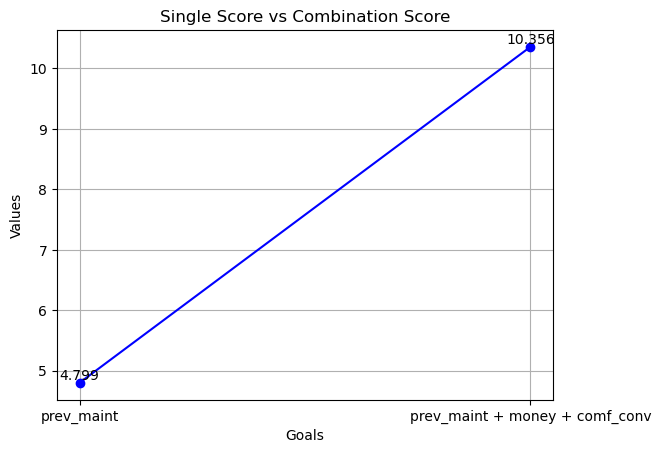

In [36]:
import matplotlib.pyplot as plt

# Define the data
numbers = [4.799, 10.356]
labels = ['prev_maint', 'prev_maint + money + comf_conv']

# Create a line chart
plt.plot(labels, numbers, marker='o', linestyle='-', color='b')
plt.xlabel('Goals')
plt.ylabel('Values')
plt.title('Single Score vs Combination Score')

for i in range(len(numbers)):
    plt.text(labels[i], numbers[i], f'{numbers[i]:.3f}', ha='center', va='bottom')

# Show the plot
plt.grid(True)
plt.show()

In [38]:
import plotly.graph_objects as go

# Define the data
numbers = [4.799, 10.356]
labels = ['prev_maint', 'prev_maint + money + comf_conv']

# Create a line chart
fig = go.Figure(data=go.Scatter(x=labels, y=numbers, mode='lines+markers', line=dict(color='blue'), marker=dict(symbol='circle', size=10)))
fig.update_layout(title='Single Score vs Combination Score',
                  xaxis_title='Goals',
                  yaxis_title='Values')

# Annotate the data points with their values
for label, number in zip(labels, numbers):
    fig.add_annotation(x=label, y=number, text=f'{number:.3f}', showarrow=True)

# Show the plot
fig.show()